# Stroke Prediction
The project inspects Stroke Prediction Dataset from Kaggle. 

The primary objectives are to clean the data, perform exploratory data analysis, statistical analysis, and apply various machine learning models for target variable Stroke prediction. Stroke prediction model must be calibrated for saving patient lives, as well as saving hospital time. 

## Dataset
Dataset can be downloaded from [Kaggle](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from unidecode import unidecode


from imblearn.over_sampling import SMOTE
import joblib

from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import (train_test_split, RandomizedSearchCV)
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score, roc_curve, auc, roc_auc_score)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.impute import KNNImputer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd

from xgboost import XGBClassifier

import eli5
from eli5.sklearn import PermutationImportance
from lime.lime_tabular import LimeTabularExplainer

import warnings
from sklearn.exceptions import UndefinedMetricWarning


%load_ext autoreload
%autoreload 2
from help_tool import help_tool

In [2]:
"""Setting graph parameters"""
sns.set_theme(style='whitegrid')
sns.set_palette('rocket')

Cleaning data before model creation. 

Data is cleaned the same way as in EDA: 
* People younger than 18 years old are removed as children and adults have different healthy BMI parameters
* Gender 'Other' has only 1 instance
* Never Worked people have 5 instances and represent people < 25 years old, while Stroke emerges at middle age.

Imputations made to fill in missing values of BMI and Smoking_status, both uses K-Nearest Neighbors (KNN). Missing values will be fed into models as new features: 'Bmi_was_missing', 'Smoking_status_was_missing'

In [3]:
stroke_data = help_tool.csv_download(
    r"..\Stroke_Prediction\archive\healthcare-dataset-stroke-data.csv").drop(
        columns=['Id']
)

stroke_data['Age'] = stroke_data['Age'].astype(int)

# Dropping 'Gender' = 'Other'
stroke_data = stroke_data[
    (stroke_data['Age'] >= 18)
    & (stroke_data['Gender'] != 'Other')
    & (stroke_data['Work_type'] != 'Never_worked')
]


# Scalling 0 to 1, as KNN is sensitive to neighbor distince
stroke_data['Age'] = stroke_data['Age']/100
stroke_data['Avg_glucose_level'] = stroke_data['Avg_glucose_level']/300
stroke_data['Bmi'] = stroke_data['Bmi']/100

# Ordinal encoding for Smoking_status
stroke_data['Smoking_status'].replace(
    {
        'Unknown': np.nan,
        'never smoked': 0,
        'formerly smoked': -1,
        'smokes': 1
    }, inplace=True)

# Converting Binary answer features to 1/0
stroke_data = help_tool.dummy_columns(
    stroke_data, ['Gender', 'Ever_married', 'Residence_type'])
stroke_data.drop(columns=['Gender_Male', 'Residence_type_Rural'], inplace=True)
stroke_data.rename(
    columns={'Residence_type_Urban': 'Residence_Urban'}, inplace=True)

# Imputation with extension
stroke_data['Smoking_status_was_missing'] = stroke_data['Smoking_status'].isnull(
).astype(int)

stroke_data['Bmi_was_missing'] = stroke_data['Bmi'].isnull().astype(int)


stroke_data_dummies = help_tool.dummy_columns(stroke_data, ['Work_type'])

Finding for BMI and Smoking_status using K-Nearest Neighbors (KNN) Imputation

In [4]:
# Removing non-scalled features
def_imputation = stroke_data_dummies.drop(
    ['Bmi_was_missing', 'Smoking_status_was_missing'], axis=1)


# KNNImputer for NaN values
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imputer.fit(def_imputation)
imputed_features = imputer.transform(def_imputation)
imputed_df = pd.DataFrame(imputed_features, columns=def_imputation.columns)

In [5]:
# Reseting indexes as they got uneven after imputation
imputed_df.reset_index(drop=True, inplace=True)
stroke_data.reset_index(drop=True, inplace=True)

# Assigning new values
stroke_data['Bmi'] = imputed_df['Bmi']
stroke_data['Smoking_status'] = imputed_df['Smoking_status'].round().astype(int)


stroke_data['Smoking_status'].replace(
    {
        0: 'never smoked',
        -1: 'formerly smoked',
        1: 'smokes'
    },
    inplace=True)

Data is ready for modeling, no missing values or duplicates

In [6]:
stroke_data_dummies = help_tool.dummy_columns(
    stroke_data, ['Work_type', 'Smoking_status'])

stroke_data_dummies.columns = stroke_data_dummies.columns \
    .str.replace('Work_type_Self-employed', 'Work_type_Self_employed') \
    .str.replace('Smoking_status_formerly smoked', 'Smoking_status_formerly_smoked') \
    .str.replace('Smoking_status_never smoked', 'Smoking_status_never_smoked')

help_tool.first_look(stroke_data_dummies)

Column data types:
Age                               float64
Hypertension                        int64
Heart_disease                       int64
Avg_glucose_level                 float64
Bmi                               float64
Stroke                              int64
Gender_Female                       int32
Ever_married                        int32
Residence_Urban                     int32
Smoking_status_was_missing          int32
Bmi_was_missing                     int32
Work_type_Govt_job                  int32
Work_type_Private                   int32
Work_type_Self_employed             int32
Smoking_status_formerly_smoked      int32
Smoking_status_never_smoked         int32
Smoking_status_smokes               int32
dtype: object

Dataset has 4248 observations and 17 features
Columns with NULL values: []
Dataset has 0 duplicates


## Splitting Data 
Splitting data into 3 subsets:
* train (training) 
* validation - model tuning
* test - picking out the best model, where performance is checked on unseen data

Training data is altered by Synthetic Minority Over-sampling Technique (SMOTE) technique. Training Dataset has 4800 instances after oversampling.

In [7]:
X = stroke_data_dummies.drop('Stroke', axis=1)
y = stroke_data_dummies['Stroke']

# Sepatating data into 3 parts
(X_train, X_vt, y_train, y_vt) = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y)

(X_validation, X_test, y_validation, y_test) = train_test_split(
    X_vt, y_vt, test_size=0.5, random_state=42, stratify=y_vt)

# Applying SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Replacing training data with oversampled data
(X_train, y_train) = (X_train_resampled, y_train_resampled)

print(X_train_resampled.shape[0])
print(y_train.shape[0])

4800
4800


# Models
## Threshold tuning
* Default models have threshold of 0.5. Threshold is used for deciding category, based on category probability. 
* Pipeline can't alter threshold attribute, so thresholds will be altered manually. 
* 8 different models will be trained, including a Dummy Classifier model DummyClassifier() from sklearn (which is as good as random guessing).
* Main metric - F1 score, which combines Precision and Recall. Main model objective is to find rare stroke cases (Recall), but also not to overflood medical institutions with false positives (Precision)
Thus, threshold tuning is made to maximize F1 score.

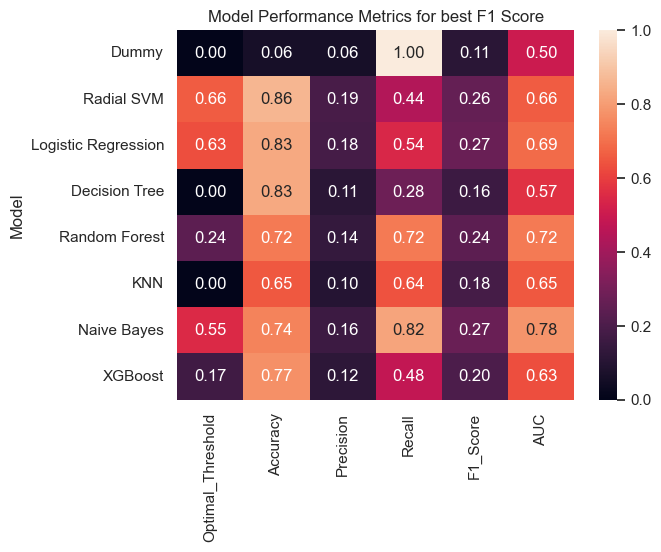

In [8]:
models = {
    # Baseline model
    'dummy': {'model': DummyClassifier(strategy='uniform', random_state=1), 'label': 'Dummy'},
    'svm': {'model': SVC(kernel='rbf', probability=True), 'label': 'Radial SVM'},
    'logisticr': {'model': LogisticRegression(max_iter=1000), 'label': 'Logistic Regression'},
    'dtree': {'model': DecisionTreeClassifier(), 'label': 'Decision Tree'},
    'rforest': {'model': RandomForestClassifier(), 'label': 'Random Forest'},
    'knn': {'model': KNeighborsClassifier(), 'label': 'KNN'},
    'nb': {'model': GaussianNB(), 'label': 'Naive Bayes'},
    'xgb': {'model': XGBClassifier(), 'label': 'XGBoost'}
}


results = []

for name, model_info in models.items():
    model = model_info['model']
    label = model_info['label']

    model.fit(X_train, y_train)

    y_proba = model.predict_proba(X_validation)[:, 1]  # Binary classification

    thresholds = np.linspace(0, 1, 100)

    # F1 score at each threshold
    f1_scores = []
    for threshold in thresholds:
        y_pred = (y_proba > threshold).astype(int)
        f1 = f1_score(y_validation, y_pred)
        f1_scores.append(f1)

    # Optimal threshold
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    y_pred_optimal = (y_proba > optimal_threshold).astype(int)

    results.append({'Model': label,
                    'Optimal_Threshold': optimal_threshold,
                    'Accuracy': accuracy_score(y_validation, y_pred_optimal),
                    'Precision': precision_score(y_validation, y_pred_optimal),
                    'Recall': recall_score(y_validation, y_pred_optimal),
                    'F1_Score': f1_score(y_validation, y_pred_optimal),
                    'AUC': roc_auc_score(y_validation, y_pred_optimal)
                    })

model_threshol_search = pd.DataFrame(results)


sns.heatmap(model_threshol_search.set_index(
    'Model').round(2), annot=True, fmt=".2f")
plt.title('Model Performance Metrics for best F1 Score')
plt.show()

After threshold tuning some optimal thresholds are 0.00 (KNN, Decision Tree, Dummy). In this study, the main goal is to find a rare health issue that affects a small subset of population. Threshold 0.0 is not good as it should manifest in High False Positive Rates. These models might not be the best, but they will be left in for compression.

Model thresholds are stored in thresholds_df dataframe. Dataframe format on thresholds were chosen for an easier model selections process.

In [9]:
thresholds_df = help_tool.feature_transpose(
    model_threshol_search, ['Model', 'Optimal_Threshold'])
thresholds_df

,Model,Dummy,Radial SVM,Logistic Regression,Decision Tree,Random Forest,KNN,Naive Bayes,XGBoost
1,Optimal_Threshold,0.0,0.656566,0.626263,0.0,0.242424,0.0,0.545455,0.171717


### Hyperparameter tuning
Hyperparameter are tuned for the previously defined thresholds. Best models will be trained on training data and validated (same process as threshold finding).

Hyperparameters are found using Random Search.

In [10]:
models = {
    'Radial SVM': (SVC(kernel='rbf', probability=True), {'C': (0.1, 100), 'gamma': (0.01, 10)}),
    'Logistic Regression': (LogisticRegression(max_iter=1000), {'C': (0.1, 100)}),
    'Decision Tree': (DecisionTreeClassifier(), {'max_depth': list(range(1, 11))}),
    'Random Forest': (RandomForestClassifier(), {'n_estimators': list(range(10, 101, 10)), 'max_depth': list(range(1, 11))}),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': list(range(2, 11)), 'weights': ['uniform', 'distance'], 'p': [1, 2]}),
    'Naive Bayes': (GaussianNB(), {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}),
    'XGBoost': (XGBClassifier(), {'max_depth': [3, 5, 7], 'learning_rate': [0.1, 0.01], 'n_estimators': [100, 200]})
}


# Suppress user warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

for model_name, (model, param_grid) in models.items():
    # Random search for the current model
    random_search = RandomizedSearchCV(
        estimator=model, param_distributions=param_grid, n_iter=10, scoring='f1', cv=5, random_state=42)
    random_search.fit(X_train, y_train)

    # Best hyperparameters
    best_params = random_search.best_params_

    # New models with the best hyperparameters
    best_model = model.__class__(**best_params)
    best_model.fit(X_train, y_train)

    # Predictions
    if hasattr(best_model, "predict_proba"):
        predictions = best_model.predict_proba(X_validation)[:, 1]
    else:
        predictions = best_model.decision_function(X_validation)

    # Adjusting decision threshold using the optimal threshold
    optimal_threshold = thresholds_df[model_name].iloc[0]
    adjusted_predictions = (predictions > optimal_threshold).astype(int)

    # New best models
    if model_name == 'Radial SVM':
        svm = best_model
        svm_param = best_params
    elif model_name == 'Logistic Regression':
        logisticr = best_model
        logisticr_param = best_params
    elif model_name == 'Decision Tree':
        dtree = best_model
        dtree_param = best_params
    elif model_name == 'Random Forest':
        rforest = best_model
        rforest_param = best_params
    elif model_name == 'KNN':
        knn = best_model
        knn_param = best_params
    elif model_name == 'Naive Bayes':
        nb = best_model
        nb_param = best_params
    elif model_name == 'XGBoost':
        xgb = best_model
        xgb_param = best_params

    print(f"Model: {model_name}")
    print(f"Best Hyperparameters: {best_params}")
    print(
        f"Adjusted F1 Score: {f1_score(y_validation, adjusted_predictions):.2f}")

Model: Radial SVM
Best Hyperparameters: {'gamma': 10, 'C': 100}
Adjusted F1 Score: 0.09
Model: Logistic Regression
Best Hyperparameters: {'C': 100}
Adjusted F1 Score: 0.25
Model: Decision Tree
Best Hyperparameters: {'max_depth': 10}
Adjusted F1 Score: 0.20
Model: Random Forest
Best Hyperparameters: {'n_estimators': 40, 'max_depth': 9}
Adjusted F1 Score: 0.21
Model: KNN
Best Hyperparameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 5}
Adjusted F1 Score: 0.17
Model: Naive Bayes
Best Hyperparameters: {'var_smoothing': 1e-09}
Adjusted F1 Score: 0.27
Model: XGBoost
Best Hyperparameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1}
Adjusted F1 Score: 0.17


After model hyperparameter tuning some F1 scores have decreased: 
* SVM: 0.11 to 0.09
* Logistic Regression: 0.27 to 0.25
* Random Forest:0.24 to 0.19
* Naive Bayes: 0.27 to 0.27
* XGBoost: 0.20 to 0.17
Unchanged or better:
* Decision Tree: 0.13 to 0.20
* KNN: 0.18 to 0.18
Unchanged or better F1 scores coincide with threshold being 0.0. This increase could be due to chance and random guessing.

## Cross Validation
Cross Validation is performed on best hypertuned models. All models have thresholds applied.

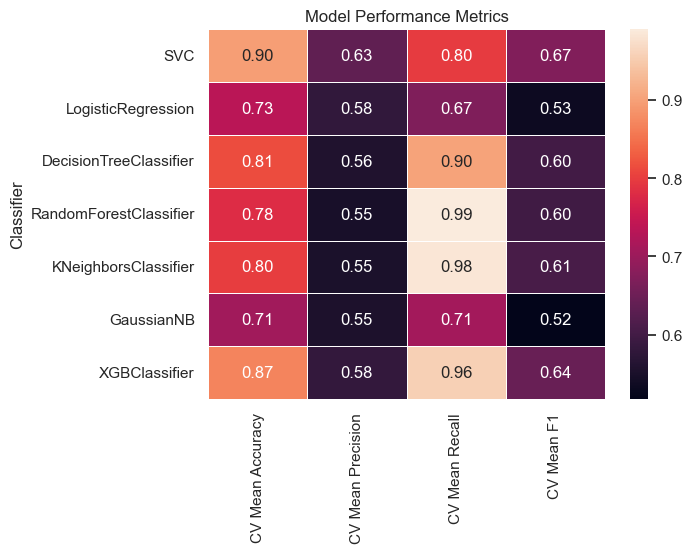

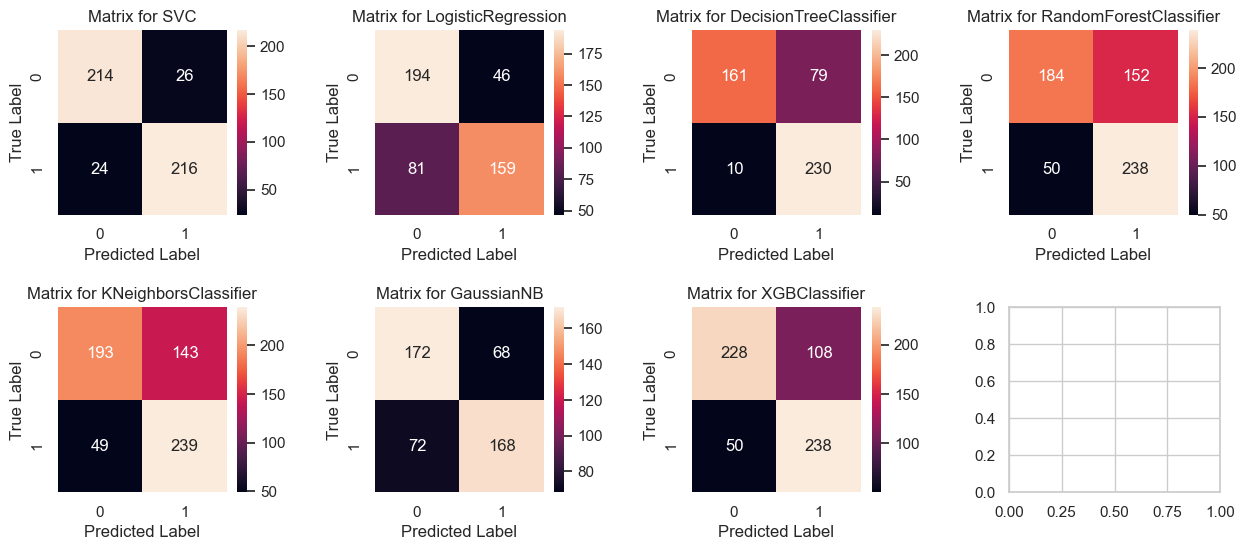

In [11]:
classifiers = {
    'Radial SVM': SVC(kernel='rbf', probability=True, C=svm_param['C'], gamma=svm_param['gamma'], random_state=42),
    'Logistic Regression': LogisticRegression(C=logisticr_param['C'], random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=dtree_param['max_depth'], random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=rforest_param['n_estimators'], max_depth=rforest_param['max_depth'], random_state=42),
    'KNN': KNeighborsClassifier(weights=knn_param['weights'], p=knn_param['p'], n_neighbors=knn_param['n_neighbors']),
    'Naive Bayes': GaussianNB(var_smoothing=nb_param['var_smoothing']),
    'XGBoost': XGBClassifier(max_depth=xgb_param['max_depth'], learning_rate=xgb_param['learning_rate'], n_estimators=xgb_param['n_estimators'], random_state=42)
}


def cross_val_plots(fold, X, y, thresholds_df, classifiers):

    model_info = help_tool.cross_val_thresholds(
        fold, X, y, thresholds_df, classifiers)

    help_tool.cross_validation_param(
        model_info.drop('Confusion Matrix', axis=1))
    help_tool.cross_validation_confusion_matrix(model_info)


cross_val_plots(10, X_train, y_train, thresholds_df, classifiers)

* Model performance metrics show an increase of F1 after Cross validation, this looks too good to be true. Threshold was tuned and best parameters found for train and validation data. Cross validation could be showing an overfitting.
* Decision tree, KNN and XGBoast have the highest value of false positives (which matches 0.00 threshold for Decision tree, KNN).

### AdaBoost (Adaptive Boosting)
Boosting 'Radial SVM', 'Logistic Regression', 'Random Forest', 'Naive Bayes' as they have the lowest value of false positives and false negatives.

In [12]:
classifiers = {
    'Radial SVM': SVC(kernel='rbf', probability=True, C=svm_param['C'], gamma=svm_param['gamma'], random_state=42),
    'Logistic Regression': LogisticRegression(C=logisticr_param['C'], random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=rforest_param['n_estimators'], max_depth=rforest_param['max_depth'], random_state=42),
    'Naive Bayes': GaussianNB(var_smoothing=nb_param['var_smoothing']),
}

adaboost_classifiers = {}

for model_name, model in classifiers.items():
    adaboost_classifier = AdaBoostClassifier(
        estimator=model, n_estimators=50, random_state=42, algorithm='SAMME')
    adaboost_classifier.fit(X_train, y_train)
    adaboost_classifiers[model_name] = adaboost_classifier

for model_name, adaboost_classifier in adaboost_classifiers.items():
    # Calculate predictions
    if hasattr(adaboost_classifier, "predict_proba"):
        predictions = adaboost_classifier.predict_proba(X_validation)[:, 1]
    else:
        predictions = adaboost_classifier.decision_function(X_validation)

    # Adjust decision threshold using the optimal threshold (assuming thresholds_df is defined)
    optimal_threshold = thresholds_df[model_name].iloc[0]
    adjusted_predictions = (predictions > optimal_threshold).astype(int)

    f1 = f1_score(y_validation, adjusted_predictions)

    fpr, tpr, _ = roc_curve(y_validation, adjusted_predictions)
    roc_auc = auc(fpr, tpr)

    print(f"Model: {model_name}")
    print(f"Validation F1: {f1:.2%}")
    print(f"ROC AUC: {roc_auc:.2f}")

Model: Radial SVM
Validation F1: 0.00%
ROC AUC: 0.50
Model: Logistic Regression
Validation F1: 25.45%
ROC AUC: 0.65
Model: Random Forest
Validation F1: 11.11%
ROC AUC: 0.50
Model: Naive Bayes
Validation F1: 24.45%
ROC AUC: 0.75


In [13]:
thresholds_df['Radial SVM ADA'] = thresholds_df['Radial SVM'].iloc[0]
thresholds_df['Logistic Regression ADA'] = thresholds_df['Logistic Regression'].iloc[0]
thresholds_df['Random Forest ADA'] = thresholds_df['Random Forest'].iloc[0]
thresholds_df['Naive Bayes ADA'] = thresholds_df['Naive Bayes'].iloc[0]

AdaBoast seam to have made the best models worse for 'Radial SVM', 'Logistic Regression', 'Random Forest', 'Naive Bayes'. Their F1 and AUC scores decreased, compared to default models.

## ROC on TEST data (3rd partition)
Finally, applying the 3rd dataset (test) for finding the best model. 'Naive Bayers' is the best model for F1 and AUC scores: 0.19 and 0.72

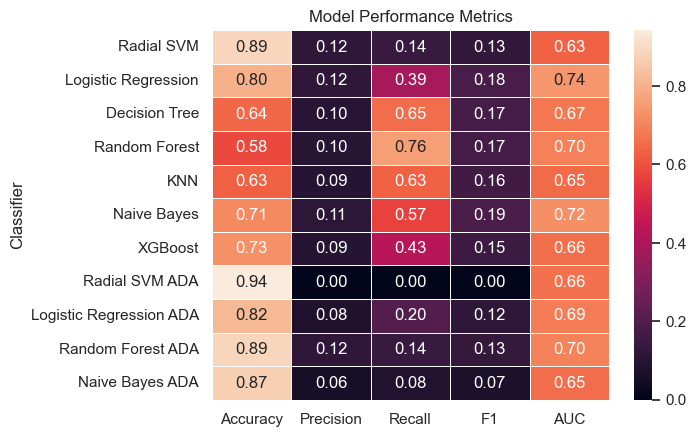

In [14]:
models = [svm, logisticr, dtree, rforest, knn, nb, xgb,
          adaboost_classifiers['Radial SVM'],
          adaboost_classifiers['Logistic Regression'],
          adaboost_classifiers['Random Forest'],
          adaboost_classifiers['Naive Bayes']
          ]
model_name = thresholds_df.iloc[:, 2:].columns.to_list()


metric_scores = help_tool.model_score_test(
    models, model_name, thresholds_df, X_test, y_test)
help_tool.cross_validation_param(metric_scores)

Saving Best Model to pickle file. Threshold will be added manualy.

In [15]:
# Save model as pickle file
joblib.dump(nb, "model.pkl")

thresholds_df['Naive Bayes']

1    0.545455
Name: Naive Bayes, dtype: object

# Model interpretation
Lets examine which features had the biggest impact for 'Naive Bayers' model 

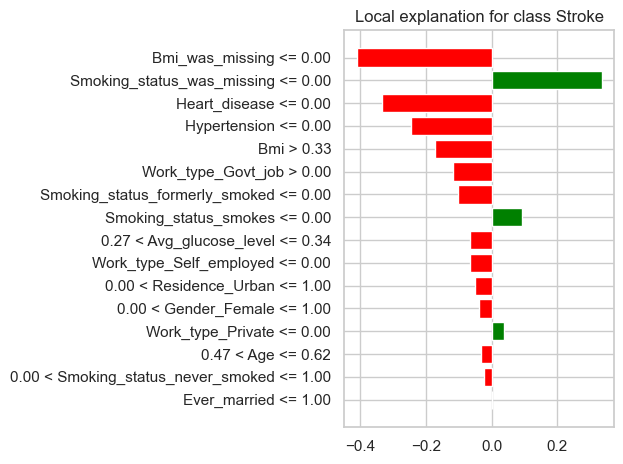

In [16]:
explainer = LimeTabularExplainer(X_train.values,
                                 feature_names=X_train.columns,
                                 class_names=['Non-Stroke', 'Stroke'])

exp = explainer.explain_instance(X_train.iloc[-1].values,
                                 nb.predict_proba,
                                 num_features=len(X_train.columns))


fig = exp.as_pyplot_figure()


fig.tight_layout()

* Class 'Stroke' in 'Naive Bayers' is impacted by 'Bmi_was_missing' and 'Smoking_status_was_missing'. Certain groups of people refuse to answer questions when they are non-applicable/insulting/obvious. 
* People who have filled in BMI (are not hiding it - one possible way is BMI had 2 digits in the application), don't have hypertension. heart_disease and don't smoke, lower < 33 BMI are  less likely to have a stroke.
* Marital status has no affect on Stroke.

Permutations show similar picture, with 'Bmi_was_missing' having the biggest impact to Stoke predictions. Interestingly, Age doesn't have a big impact on permutations, neither is being married.

In [17]:
perm = PermutationImportance(nb, random_state=42).fit(
    X_validation, y_validation)

eli5.show_weights(perm, feature_names=X_validation.columns.tolist())

Weight,Feature
0.0125 ± 0.0057,Bmi_was_missing
0.0115 ± 0.0050,Avg_glucose_level
0.0094 ± 0.0047,Heart_disease
0.0089 ± 0.0092,Work_type_Govt_job
0.0061 ± 0.0048,Residence_Urban
0.0047 ± 0.0039,Smoking_status_formerly_smoked
0.0045 ± 0.0031,Smoking_status_never_smoked
0.0038 ± 0.0048,Hypertension
0.0028 ± 0.0044,Smoking_status_smokes
0.0014 ± 0.0054,Work_type_Self_employed


# Conclusions
Model task - predict rare stroke event for Medical Institutions. All models have been threshold tuned for F1: 
* Best model is 'Naive Bayers' with F1 score of 0.19 and AUC of 0.72. 
* Synthetic Minority Over-sampling Technique (SMOTE) was used for imbalanced data.
* AdaBoast was tested, but didn't bring improvement.
* Biggest predictor is 'Bmi_was_missing'. This could be due to BMI going up to 3 digits, but data had only 2 digits BMI. This theory could explain the 'Bmi_was_missing' importance.
* Merital status has no affect on Stroke, but general health does - people with no heart disease, hypertension, < 33 BMI and non smokers are less likely to get a stroke.